In [ ]:
import warnings
warnings.filterwarnings('ignore')

#### **API 키 설정**

#### **State 설정**

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

#### **도구 설정(웹 검색, PythonREPL)**

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool

web_search = TavilySearchResults(max_results=2)
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. chart labels should be written in English.
    This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )
tools=[web_search, python_repl]
tool_node = ToolNode(tools)

#### **에이전트에게 도구 인지시키기**

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def agent(state: State):
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": [result]}

In [4]:
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [5]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(State)

workflow.add_node("agent", agent)
workflow.add_node("tool", tool_node)

workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(

    "agent",

    should_continue,

    {
        "continue": "tool",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tool", "agent")

# Set up memory
memory = MemorySaver()

graph = workflow.compile(checkpointer=memory, interrupt_before=["tool"])

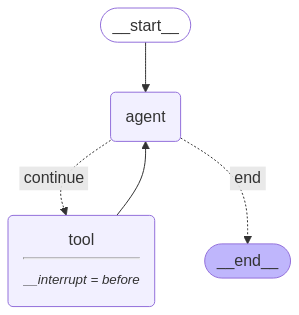

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
initial_input = {"messages": [HumanMessage(content="미국의 최근 5개년(~2023) GDP 차트를 그려줄래?")]}
thread = {"configurable": {"thread_id": "13"}}
async for chunk in graph.astream(initial_input,thread, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")

Receiving update from node: 'agent'
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_afNVpR8zyLAN5Vs8zsREYqPp', 'function': {'arguments': '{"query":"US GDP data for the last 5 years 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 168, 'total_tokens': 198, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BL5pWNCWLzp7gNto3eUKzmTQnYTV8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-721514d7-16b0-4721-b616-a45fcfc3dbcd-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'US GDP data for the last 5 years 2023'}, 'id': 'call_afNVpR8zyLAN5Vs8zsREYqPp', 'type': 'to

In [8]:
async for chunk in graph.astream(None,thread, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")

Receiving update from node: 'tool'
{'messages': [ToolMessage(content='[{"title": "United States GDP - Trading Economics", "url": "https://tradingeconomics.com/united-states/gdp", "content": "The Gross Domestic Product (GDP) in the United States was worth 27360.94 billion US dollars in 2023, according to official data from the World Bank. The GDP value of the United States represents 25.95 percent of the world economy. source: World Bank [...] | GDP | 27360.94 | 25744.11 | USD Billion | Dec 2023 |\\n| GDP Annual Growth Rate | 2.50 | 2.70 | percent | Dec 2024 |\\n| GDP Constant Prices | 23530.90 | 23400.30 | USD Billion | Dec 2024 |\\n| GDP Growth Rate | 2.30 | 3.10 | percent | Dec 2024 |\\n| GDP per Capita | 65020.35 | 63720.76 | USD | Dec 2023 |\\n| GDP per Capita PPP | 73637.30 | 72165.48 | USD | Dec 2023 | [...] GDP in the United States averaged 8536.37 USD Billion from 1960 until 2023, reaching an all time high of 27360.94 USD Billion in 2023 and a record low of 541.99 USD Billion i

Python REPL can execute arbitrary code. Use with caution.


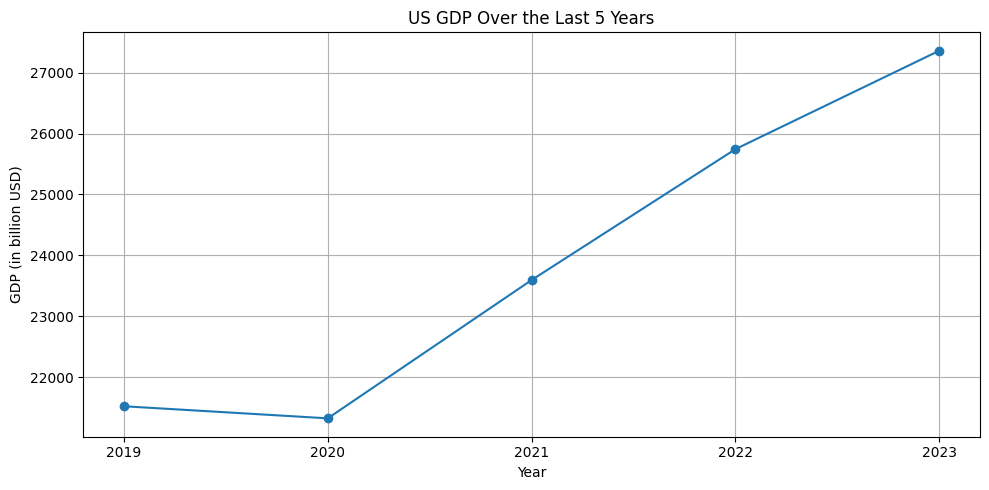

Receiving update from node: 'tool'
{'messages': [ToolMessage(content="Successfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# Data for the GDP of the US for the last 5 years\nyears = [2019, 2020, 2021, 2022, 2023]\nGDP = [21521.40, 21322.95, 23594.03, 25744.11, 27360.94]  # in billion USD\n\nplt.figure(figsize=(10, 5))\nplt.plot(years, GDP, marker='o')\nplt.title('US GDP Over the Last 5 Years')\nplt.xlabel('Year')\nplt.ylabel('GDP (in billion USD)')\nplt.xticks(years)\nplt.grid()\nplt.tight_layout()\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', id='4b3e3d43-72d2-48bb-9b07-0c9faa30b6c8', tool_call_id='call_7uj8ZjNqx80dtMS04Ir4Aqys')]}



Receiving update from node: 'agent'
{'messages': [AIMessage(content='Here is the chart showing the US GDP over the last 5 years:\n\n- **2019**: $21,521.40 billion\n- **2020**: $21,322.95 billion\n- **2021**: $23,594.03 billion\n- **2022**: $25,744.11 billion\n- **2023**: $

In [9]:
async for chunk in graph.astream(None,thread, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")

In [10]:
async for chunk in graph.astream(None,thread, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")

In [11]:
async for chunk in graph.astream(None,thread, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")